<img src = "https://drive.google.com/uc?export=view&id=1XCFjEoG1OLaFbuntEH_PC7vtsII9wNfh" alt = "Encabezado MLDS" width = "100%">  </img>

# **Integrantes:**
- Alejandro Rangel Retavisca, jarangelr@unal.edu.co
- Eder Fabian Ruiz, edruiza@unal.edu.co 

# **Diseño e implementación experimental**
---

Este notebook es una plantilla que le puede servir como guía para el tercer entregable del proyecto aplicado.

## **1. Particion del conjunto de datos**
---

Nuestros datos son tomados de un sistema de posicionamiento GPR-UWB (Ground Penetranting Radar), este genera unas imagenes de objetos enterrados. Para este proyecto se queire clasificar dos tipos de objetos entrerrados, el primero son unos artefactos explosivos Inertes (Materiales sustitutos), y el segundo son Clutter o elementos diferentes a artefactos explosivos. 

En la siguiente Imagen se obseva un Radar grama puro y otros radargrama procesados. 

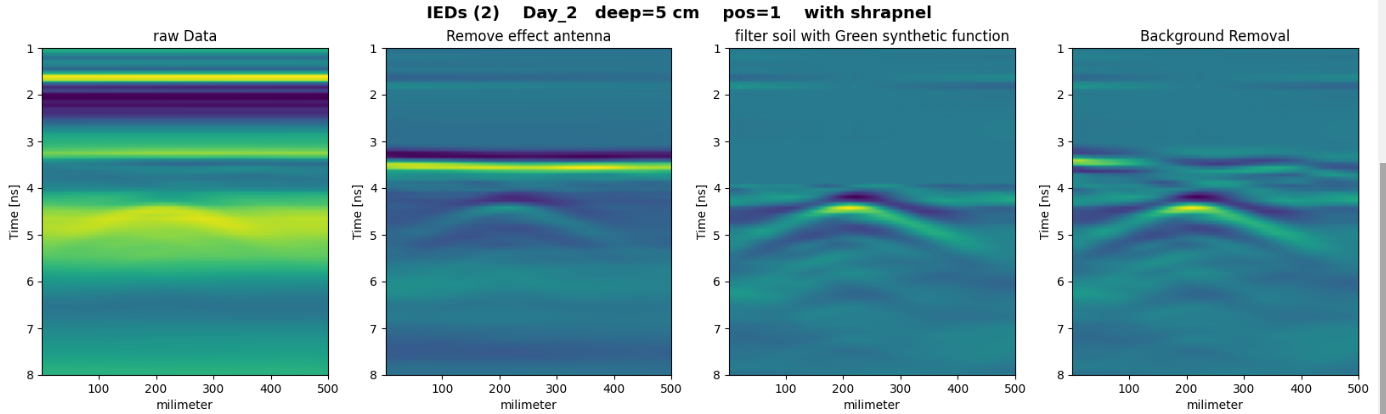

Como se puede ver en las imagenes el objeto muestra una elipse la cual es muy clara cuando se procesa. pero para ete proyecto se realizar con las señales puras sin procesar. 

Los datos estan almacenados en Tensores en google Drive, uno se llama *datas* y el otro *labels*. 

Inicialmenete se extraen los datos y luego se hace la partici de estos. Los datos son 600 imagenes en total de 100x500 pixeles, donde 120 son de cilindros, y 480 son de artefactos explosivos inerte, es un dataset descompensado pero luego usando tecnicas se le da más peso a estos datos. 

## Descarga de datos

Los datos se encuentran en Drive, mediante link publicos se realiza la respectiva descarga. 

In [2]:
## Descarga de datos. 
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import urllib.request

# url='https://drive.google.com/file/d/1oN9t1Q2tx9akQCdyB8ffbgFUI6o3Rdhs/view?usp=sharing'
# filename = 'datas'
# urllib.request.urlretrieve(url, filename)

# url='https://drive.google.com/file/d/1V1ArROLkfar0Oq_HIXv4kjKQGfh9SZDh/view?usp=sharing'
# filename = 'labels'
# urllib.request.urlretrieve(url, filename)

Mounted at /content/drive


In [5]:
## Cargar archivos
import h5py

# with h5py.File('/content/datas.h5', 'r') as f:
#     X = f['datas'][:]

# with h5py.File('/content/labels.h5', 'r') as f:
#     y = f['labels'][:]

with h5py.File('/content/drive/Shareddrives/TII UNAL GPR/Machine Learning Models/Data Training/Raw Data/datas.h5', 'r') as f:
    X = f['datas'][:]

with h5py.File('/content/drive/Shareddrives/TII UNAL GPR/Machine Learning Models/Data Training/Raw Data/labels.h5', 'r') as f:
    y = f['labels'][:]



print(f'Tensor con  {y.shape[0]} imagenes {X.shape}')
print(f'vector con  {y.shape[0]} etiquetas {y.shape}')

Tensor con  1901 imagenes (1901, 100, 500)
vector con  1901 etiquetas (1901,)


## Grafico de una de las imagenes
Se grafica unos de los radar gramas apartir de los datos de entrada con su respectiva etiqueta. 

Text(0, 0.5, 'Time [ns]')

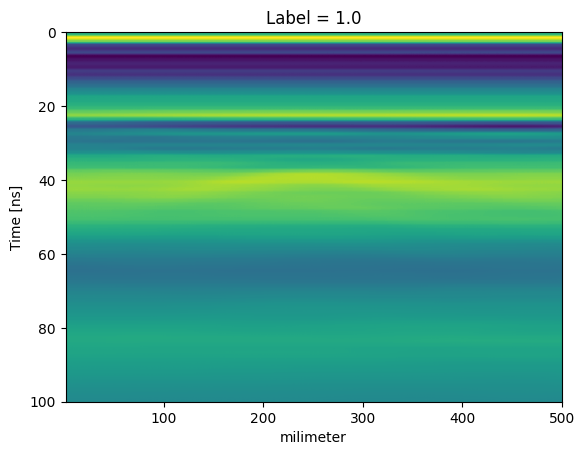

In [6]:
# Grafica de un radargrama  
import matplotlib.pyplot as plt
img=1

plt.title(f'Label = {y[img]}', fontsize=12)
plt.imshow(X[img], extent=[1, 500, 100, 0], aspect='auto')
plt.xlabel('milimeter')
plt.ylabel('Time [ns]')

In [7]:
# ---****---
# Separación de datos 
from sklearn.model_selection import train_test_split


# Primera división: 60% entrenamiento, 40% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=15)

# Segunda división: 50% prueba, 50% validación
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=15)

print(f'Tamaño de las imagenes de Entrenamiento {X_train.shape}')
print(f'Tamaño de las imagenes de evaluación {X_val.shape}')
print(f'Tamaño de las imagenes de prueba {X_test.shape}')

Tamaño de las imagenes de Entrenamiento (1140, 100, 500)
Tamaño de las imagenes de evaluación (380, 100, 500)
Tamaño de las imagenes de prueba (381, 100, 500)


In [8]:
#Vemos las etiquetas de los labe de training

print(y_train)  

#Deben estar mezclados.   

[1. 1. 1. ... 1. 0. 0.]


## **2. Selección y diseño de modelos**
---

Seleccione el/los modelo/s a explorar para aplicar sobre el conjunto de datos. Recuerde, la selección del modelo está influenciada por diferentes factores. Si el problema es de análisis de imagen, muy seguramente hay que explorar diversas redes neuronales convolucionales. Si el problema está relacionado con NLP, muy seguramente hay que explorar modelos basados en Tranformers.

Además, debe definir cuál es su problema:

- **Regresión**: se busca estimar un valor continúo a partir de los datos.
- **Clasificación**: permite estimar un valor categórico a partir de los datos.
- **Agrupamiento**: permite encontrar grupos de datos similares.
- **Otros modelos**: recuerde que dispone de otros tipos de tareas supervisadas y no supervisadas.

En cualquier caso los profundos disponibles en _TensorFlow_ constituyen una base sobre la que usted debe definir un clasificador/regresor/_encoder_/_decoder_ final, compuesto de una o más capas densas, con opción de incluir _dropout_ o capas de normalización. 

Justifique la escogencia y diseño de los modelos a explorar:

En términos más detallados, el proyecto busca aplicar técnicas de aprendizaje profundo en el análisis de imágenes B-scan obtenidas mediante el uso de un sistema de radar de penetración terrestre (GPR). La idea es entrenar una red neuronal convolucional (CNN) para clasificar automáticamente las imágenes B-scan en dos categorías: objetos explosivos improvisados (IEDs) y objetos no explosivos (clutter). Para lograr esto, se seguirá una aproximación de arquitectura de CNN convencional, que consta de varias capas convolucionales y de pooling en secuencia, para extraer características relevantes de la imagen.

Después de la fase de extracción de características, se incluirá una capa densa en la parte final de la CNN, que actuará como clasificador y utilizará las características extraídas de la imagen para predecir si la imagen corresponde a un IED o a clutter. Para llevar a cabo el entrenamiento de la CNN, se utilizará un conjunto de datos etiquetados previamente que contenga imágenes B-scan con y sin presencia de IEDs.

La ventaja del uso de técnicas de aprendizaje profundo como las CNN es que la red puede aprender automáticamente patrones y características relevantes en las imágenes, en lugar de depender de un modelo previo predefinido. De esta manera, se espera que la CNN sea capaz de realizar una clasificación precisa de las imágenes B-scan.

## **3. Implementación de los modelos**
---

Implemente los modelos descritos anteriormente usando herramientas de _TensorFlow_. Recuerde que puede aplicar técnicas de aumentación de datos, si es necesario.

In [9]:
# ---**INGRESE SU CÓDIGO**---
# Seleccionamos la versión más reciente de Tensorflow 2.0
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, random
%matplotlib inline
plt.style.use("ggplot")
# Seleccionamos una semilla para los RNG
tf.random.set_seed(0)
np.random.seed(0)

In [10]:
conv_net = tf.keras.models.Sequential()
conv_net.add(tf.keras.layers.Input(shape=(100, 500, 1)))

- Primer bloque

In [11]:
conv_net.add(tf.keras.layers.Conv2D(filters=36, 
                                    kernel_size=3,
                                    activation='relu'))

conv_net.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

- Segundo bloque

In [12]:
conv_net.add(tf.keras.layers.Conv2D(filters=36, 
                                    kernel_size=3,#
                                    activation='relu'))

conv_net.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

- Tercer bloque

In [13]:
conv_net.add(tf.keras.layers.Conv2D(filters=36, 
                                    kernel_size=3,
                                    activation='relu'))

conv_net.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

- Capa flatten

In [14]:
conv_net.add(tf.keras.layers.Flatten())

- Clasificador

In [15]:
# Capa densa intermedia
conv_net.add(tf.keras.layers.Dense(units=512, 
                                   activation='relu'))
# Capa de salida
conv_net.add(tf.keras.layers.Dense(units=1, 
                                   activation='sigmoid'))

Visualización

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 498, 36)       360       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 249, 36)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 247, 36)       11700     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 123, 36)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 121, 36)       11700     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 60, 36)       0

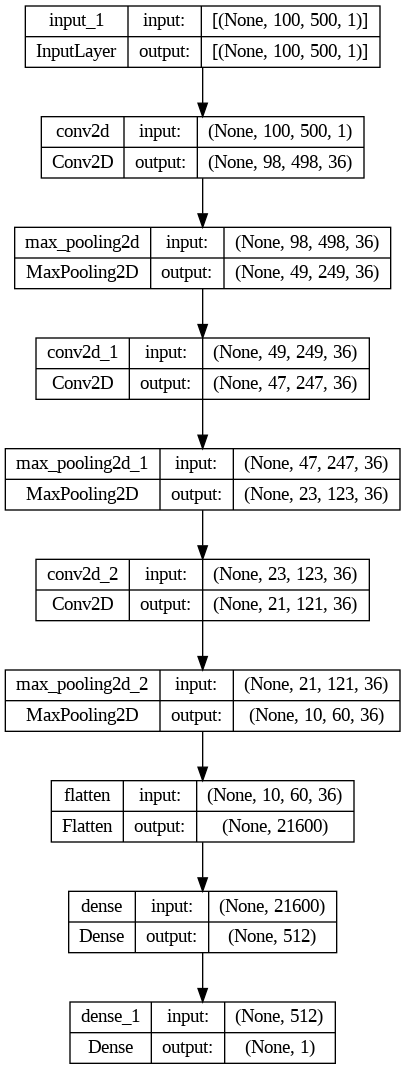

In [16]:
conv_net.summary()
tf.keras.utils.plot_model(conv_net,show_shapes=True)

## **4. Entrenamiento del Modelo y Selección de Hiperparámetros**
---


In [17]:
# Función de entrenamiento_cambio optimizer
conv_net.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Entrenamos el modelo
history = conv_net.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_val), batch_size=32, verbose=1)

Epoch 1/30
36/36 [==============================] - 18s 108ms/step - loss: 0.5597 - accuracy: 0.7474 - val_loss: 0.5824 - val_accuracy: 0.7263
Epoch 2/30
36/36 [==============================] - 2s 42ms/step - loss: 0.5176 - accuracy: 0.7825 - val_loss: 0.5514 - val_accuracy: 0.7711
Epoch 3/30
36/36 [==============================] - 1s 40ms/step - loss: 0.4943 - accuracy: 0.8053 - val_loss: 0.5190 - val_accuracy: 0.7737
Epoch 4/30
36/36 [==============================] - 1s 41ms/step - loss: 0.4674 - accuracy: 0.8114 - val_loss: 0.5280 - val_accuracy: 0.7711
Epoch 5/30
36/36 [==============================] - 1s 41ms/step - loss: 0.4709 - accuracy: 0.8114 - val_loss: 0.5516 - val_accuracy: 0.7474
Epoch 6/30
36/36 [==============================] - 1s 41ms/step - loss: 0.4668 - accuracy: 0.8096 - val_loss: 0.4776 - val_accuracy: 0.7711
Epoch 7/30
36/36 [==============================] - 1s 41ms/step - loss: 0.4441 - accuracy: 0.8096 - val_loss: 0.5094 - val_accuracy: 0.7658
Epoch 8/30


In [18]:
## Evaluar el modelo

loss, accuracy = conv_net.evaluate(X_val, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

12/12 [==============================] - 0s 16ms/step - loss: 0.1733 - accuracy: 0.9368
Loss: 0.1732683628797531
Accuracy: 0.9368420839309692


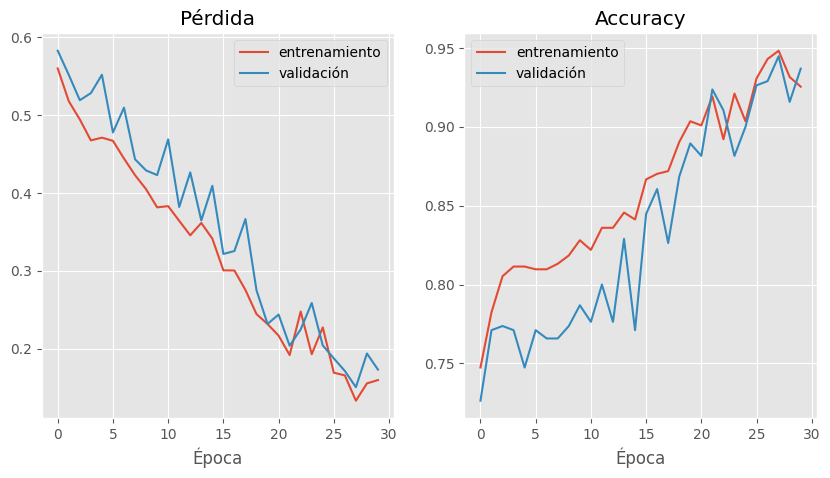

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history["loss"], label="entrenamiento")
plt.plot(history.history["val_loss"], label="validación")
plt.title("Pérdida"); plt.xlabel("Época"); plt.legend()
plt.subplot(122)
plt.plot(history.history["accuracy"], label="entrenamiento")
plt.plot(history.history["val_accuracy"], label="validación")
plt.title("Accuracy"); plt.xlabel("Época"); plt.legend()

60/60 [==============================] - 1s 15ms/step


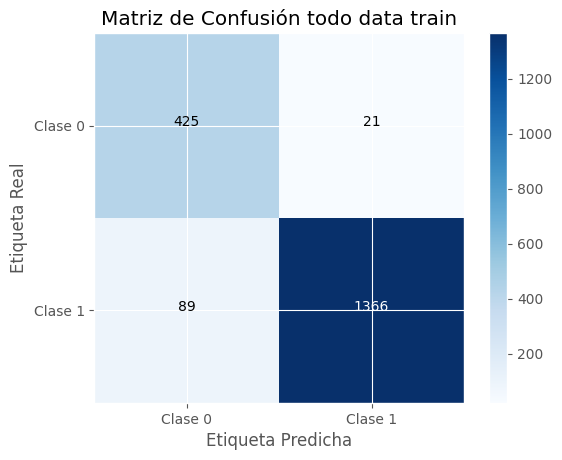

In [19]:
from sklearn.metrics import confusion_matrix

# ...

# Después de entrenar y evaluar el modelo, obtenemos las predicciones en el conjunto de prueba
y_pred = conv_net.predict(X)
y_pred = np.round(y_pred).flatten()  # Redondear las predicciones a 0 o 1 (suponiendo una clasificación binaria)

# Generar la matriz de confusión
confusion_mtx = confusion_matrix(y, y_pred)

# Visualizar la matriz de confusión
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión todo data train')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Clase 0', 'Clase 1'])
plt.yticks(tick_marks, ['Clase 0', 'Clase 1'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')

thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")


plt.show()

12/12 [==============================] - 0s 43ms/step


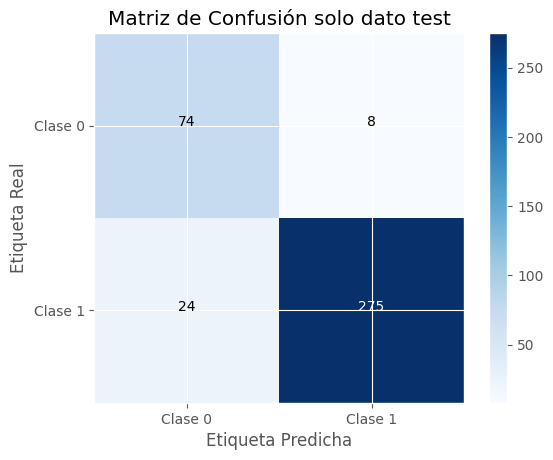

In [20]:
# Solo con datos de Evaluacion 
from sklearn.metrics import confusion_matrix

# ...

# Después de entrenar y evaluar el modelo, obtenemos las predicciones en el conjunto de prueba
y_pred = conv_net.predict(X_test)
y_pred = np.round(y_pred).flatten()  # Redondear las predicciones a 0 o 1 (suponiendo una clasificación binaria)

# Generar la matriz de confusión
confusion_mtx = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión solo dato test')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Clase 0', 'Clase 1'])
plt.yticks(tick_marks, ['Clase 0', 'Clase 1'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')

thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")


plt.show()

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/) 
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*